#### Description of the data
0. ASI01_AUS01: Australia from 15th of December to 9th of January. Was compared to TSO data
1. ASI01_IDN01: Indonesia from 10th to 21st of November
2. ASI01_MYS01: Malaysia from 30th of October to 9th of November 
3. ASI01_MYS02: Malaysia from 4th to 14th of December
4. ASI01_SGP01: Singapore from 22nd November to 2nd of December

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import diptest
from numpy import random

from scipy.stats import skew, kurtosis
from scipy.optimize import curve_fit

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import acf

import plotly.express as px
import plotly.io as pio

from MFDFA import MFDFA
from MFDFA import fgn

#### Load dataset

In [3]:
folder_path = 'C:/1.1 Asia frequency data'
file_names = os.listdir(folder_path)

dataframes = []
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path, sep=';') 
    df.iloc[:,1] = df.iloc[:,1]/1000 + 50
    dataframes.append(df)

MYS1 =  dataframes[2]
MYS1 =  MYS1[MYS1['QI'] == 0]  
    
MYS2 =  dataframes[3]
MYS2 =  MYS2[MYS2['QI'] == 0]    
# dataframes[0] is Australia, [1] is Indonesia, [2] is Malaysia01, [3] is Malaysia02, [4] is Singapore

# Combine dataframes[2] and dataframes[3]
combined_df = pd.concat([dataframes[2], dataframes[3]], ignore_index=True)

# Replace dataframes[2] and dataframes[3] with combined_df in the dataframes list
dataframes[2:4] = [combined_df]

# Now, dataframes[0] is Australia, [1] is Indonesia, [2] is the combined Malaysia, [3] is Singapore


# Only select quality QI=0
flt_dataframes = []
for df in dataframes:
    flt_df = df[df['QI'] == 0].dropna()
    flt_dataframes.append(flt_df)
    
region_dict = {0: 'Australia', 1: 'Indonesia', 2: 'Malaysia',  3: 'Singapore'}

# Group the dataframes by region
region_groups = [df.groupby(lambda x: region_dict[i]) for i, df in enumerate(flt_dataframes)] 
colors = ('#1b9e77', '#d95f02','#7570b3','#e7298a')

#### Time series plot for flt_dataframes

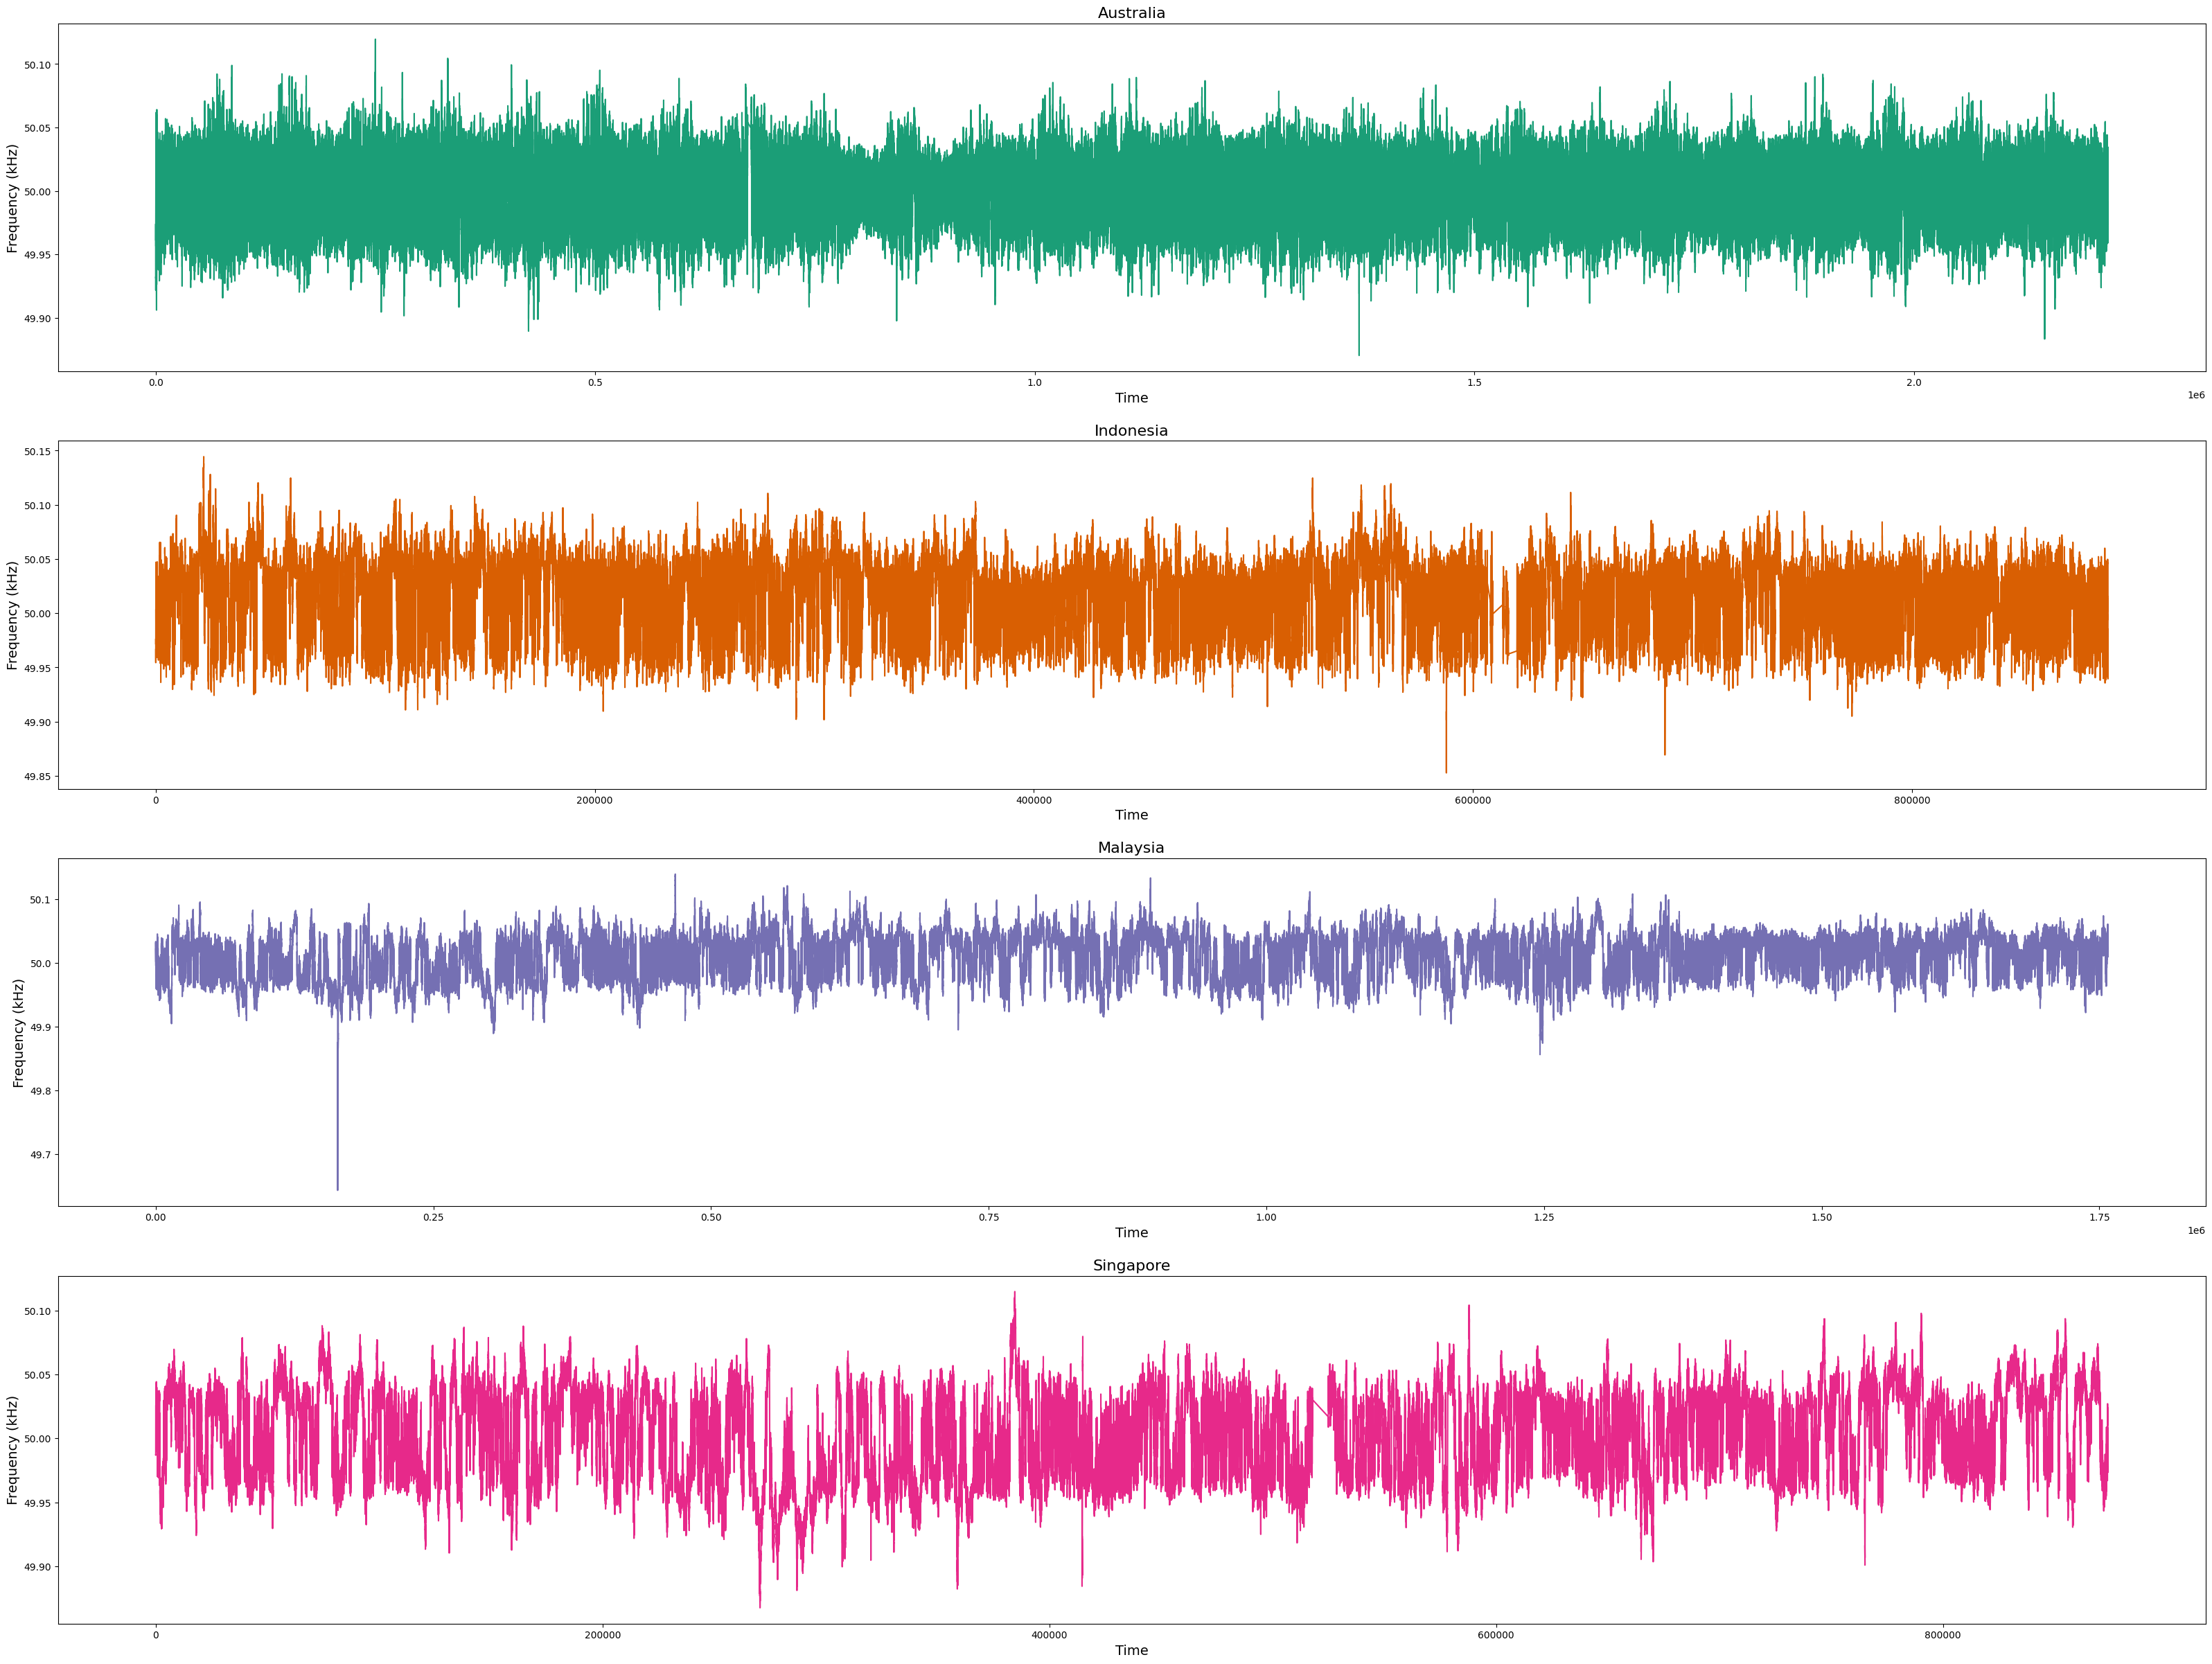

In [4]:
colors=('#1b9e77', '#d95f02','#7570b3','#e7298a')

fig, axs = plt.subplots(nrows=len(flt_dataframes), figsize=(40,30))

for i, df in enumerate(flt_dataframes):
    axs[i].plot(df['f50'],color=colors[i])
    axs[i].set_title(region_dict[i], fontsize=16)
    axs[i].set_xlabel('Time', fontsize=14)
    axs[i].set_ylabel('Frequency (kHz)',fontsize=14)

#plt.tight_layout()
plt.rcParams.update({'font.family': 'Times New Roman'})
plt.show()

#### Remove gaps

In [5]:
# Find the longest continuous part for each region
filter_data = []
for df in flt_dataframes:
    # Convert the 'Time' column to datetime type
    df['Time'] = pd.to_datetime(df['Time'])
    time_diff = df['Time'].diff()

    # Find the longest continuous part by grouping consecutive timestamps with the same difference
    groups = (time_diff != pd.Timedelta(seconds=1)).cumsum()
    max_group = groups.value_counts().idxmax()

    # Filter the DataFrame to retain only the longest continuous part
    longest_continuous_df = df[groups == max_group]
    filter_data.append(longest_continuous_df)

mys2_filter = MYS2.dropna()
filter_data[2] = mys2_filter

filter_dict = {0: 'Australia', 1: 'Indonesia', 2: 'Malaysia', 3: 'Singapore'}
%store filter_data

Stored 'filter_data' (list)


#### Time series plot for filter_data

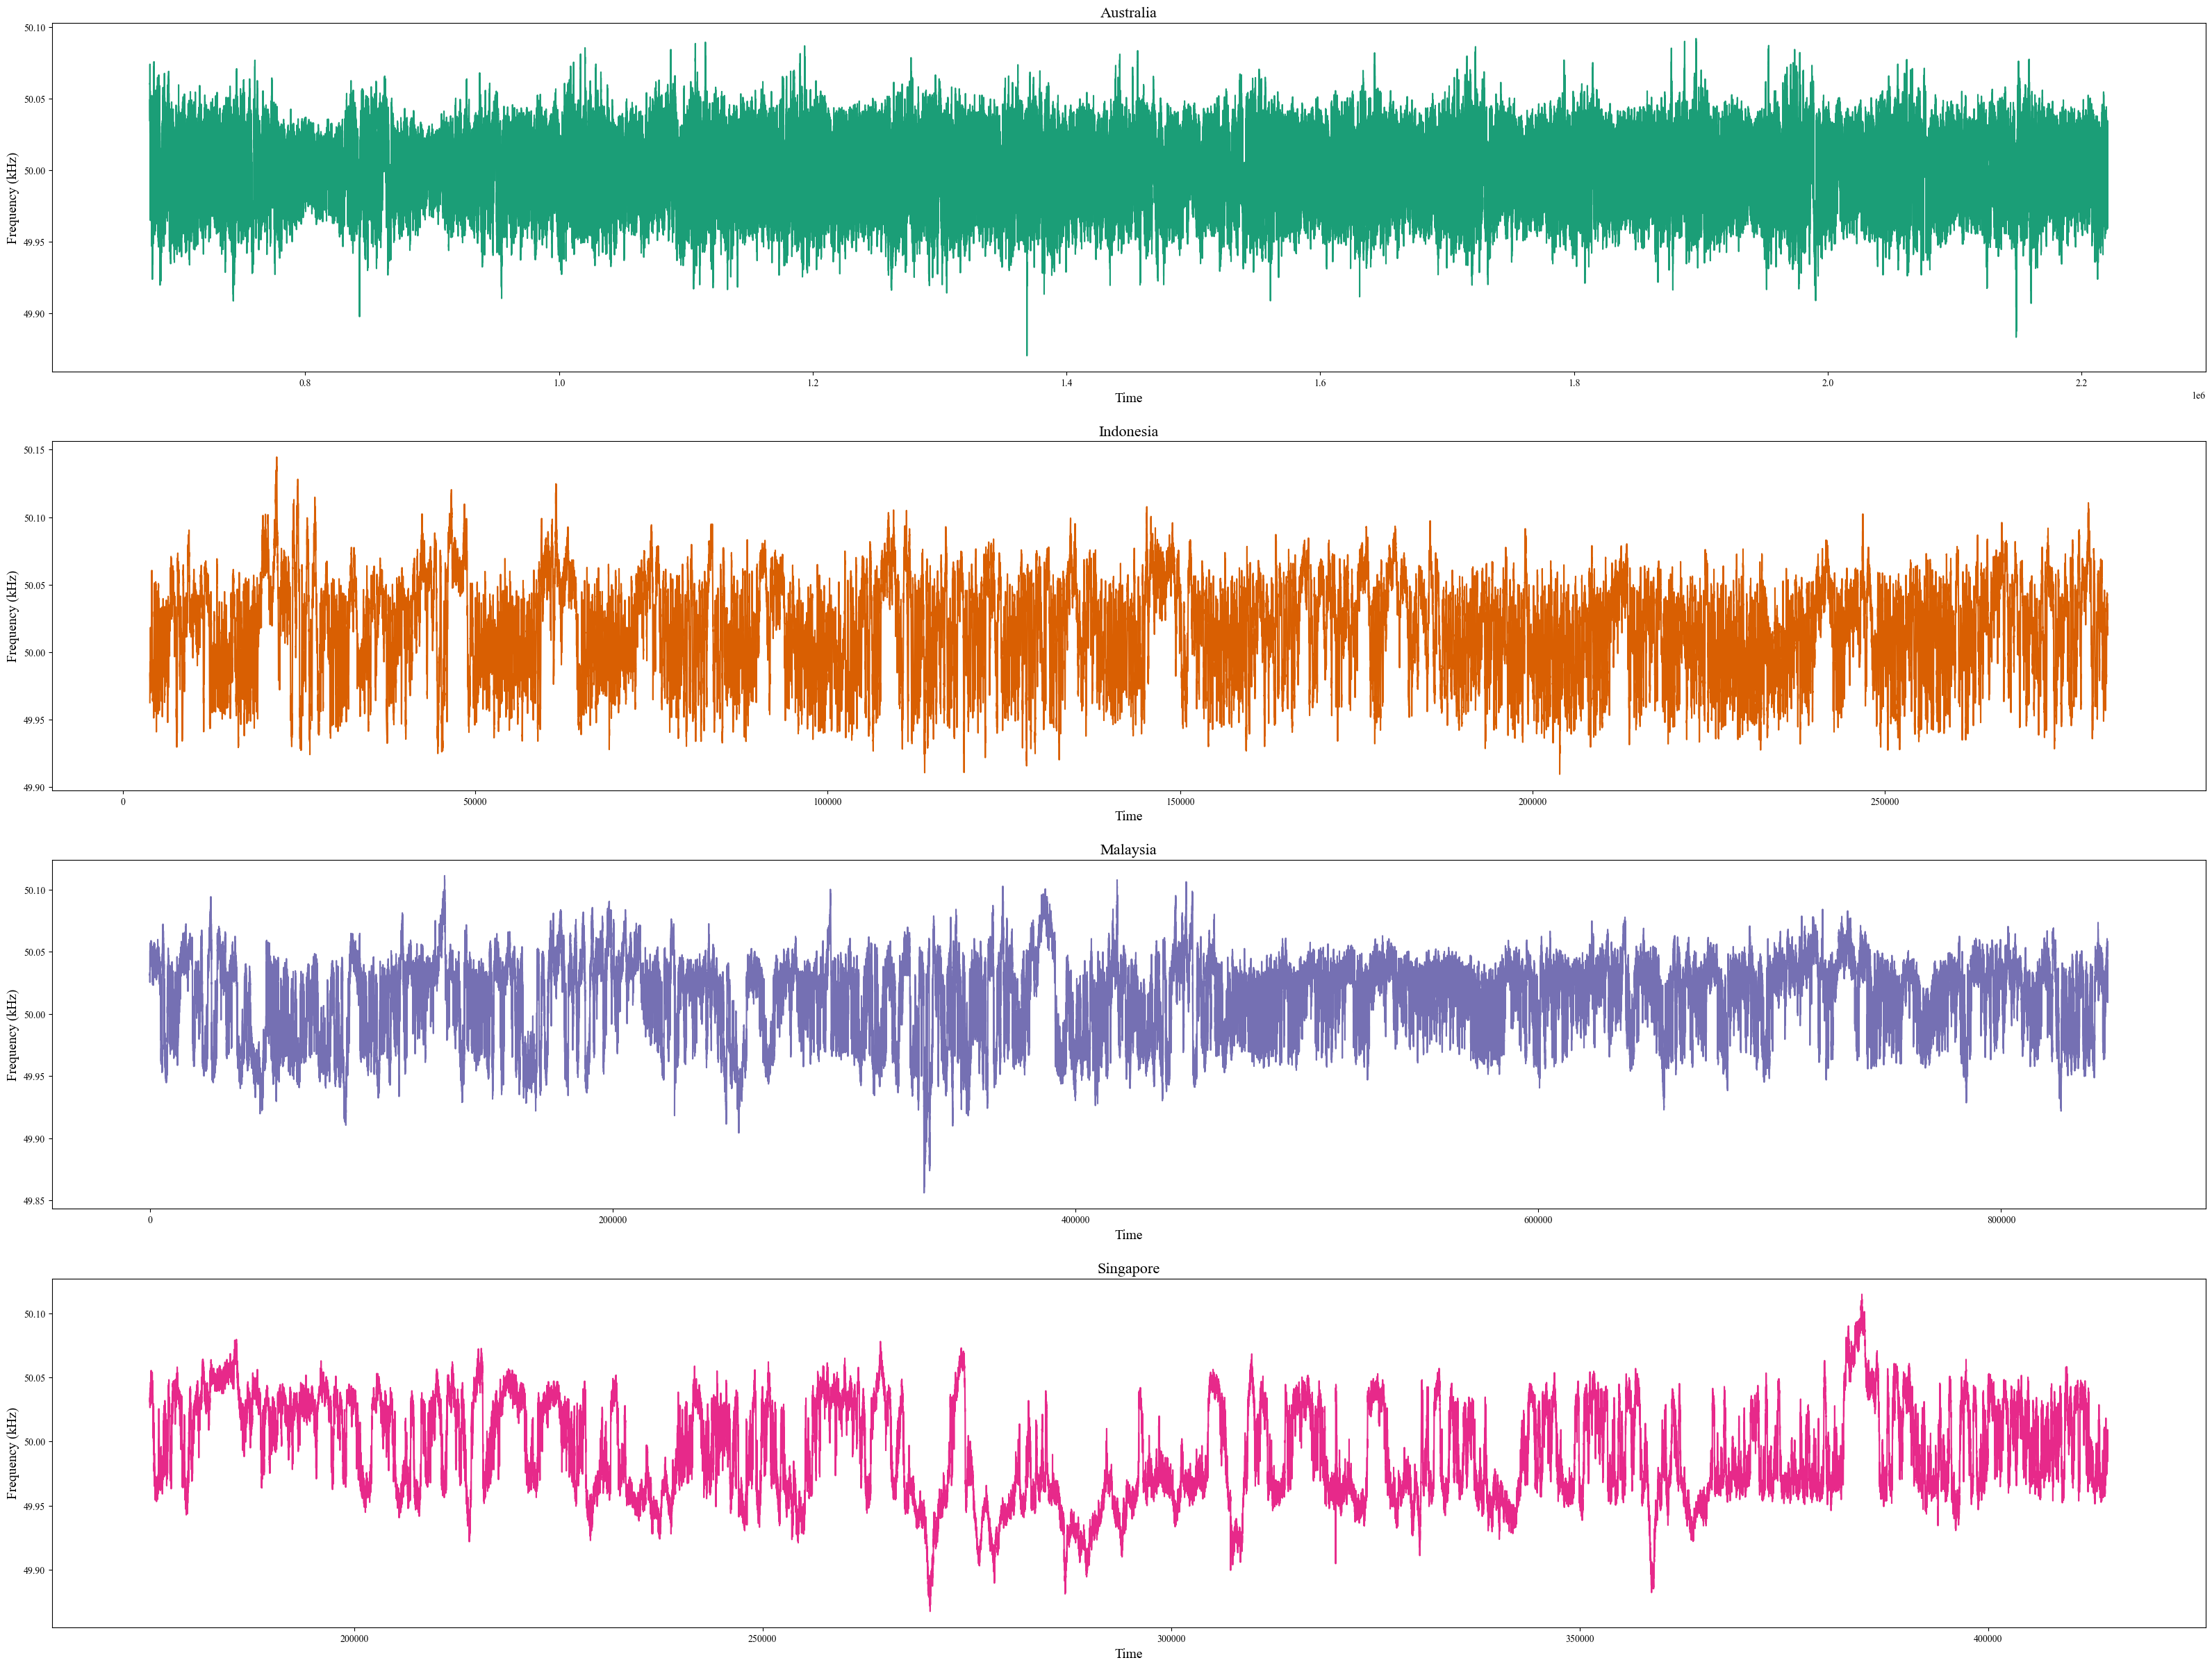

In [5]:
fig, axs = plt.subplots(nrows=len(filter_data), figsize=(40,30))

for i, df in enumerate(filter_data):
    axs[i].plot(df['f50'],color=colors[i])
    axs[i].set_title(region_dict[i], fontsize=16)
    axs[i].set_xlabel('Time', fontsize=14)
    axs[i].set_ylabel('Frequency (kHz)',fontsize=14)

#plt.tight_layout()
plt.rcParams.update({'font.family': 'Times New Roman'})
plt.show()

#### Stationary test for filter_data

In [6]:
for i, df in enumerate(filter_data):
    data = df.iloc[:, 1].dropna().values
    result = kpss(data, regression="c", nlags=0)
    test_statistic = result[0]
    p_value = result[1]

    # Assuming a 5% significance level
    critical_value_5percent = result[3]['5%']

    if test_statistic > critical_value_5percent:
        print(f"Region {filter_dict[i]}: Test Statistic = {test_statistic:.4f}, p-value = {p_value:.4f} (Non-Stationary)")
    else:
        print(f"Region {filter_dict[i]}: Test Statistic = {test_statistic:.4f}, p-value = {p_value:.4f} (Stationary)")


Region Australia: Test Statistic = 1.6452, p-value = 0.0100 (Non-Stationary)
Region Indonesia: Test Statistic = 95.4319, p-value = 0.0100 (Non-Stationary)
Region Malaysia: Test Statistic = 1469.4036, p-value = 0.0100 (Non-Stationary)
Region Singapore: Test Statistic = 1231.0041, p-value = 0.0100 (Non-Stationary)


C:\Users\wp7528\AppData\Local\Temp\ipykernel_2348\3529887331.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(data, regression="c", nlags=0)
C:\Users\wp7528\AppData\Local\Temp\ipykernel_2348\3529887331.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(data, regression="c", nlags=0)
C:\Users\wp7528\AppData\Local\Temp\ipykernel_2348\3529887331.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(data, regression="c", nlags=0)
C:\Users\wp7528\AppData\Local\Temp\ipykernel_2348\3529887331.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in 

#### Frequency distribution in Asian areas 

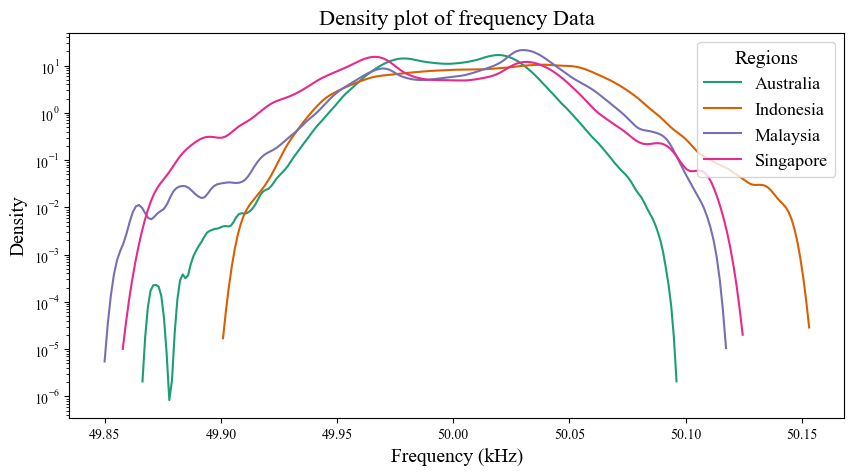

In [7]:
fig, ax = plt.subplots(figsize=(10,5))

for i, df in enumerate(filter_data):
    data = df.iloc[:,1]
    sns.kdeplot(data, color=colors[i], ax=ax, label=region_dict[i])

ax.set_title('Density plot of frequency Data',fontsize=16)
ax.set_xlabel('Frequency (kHz)',fontsize=14)
ax.set_ylabel('Density',fontsize=14)
ax.set_yscale('log') 
#ax.set_xscale('log')

plt.legend(title = "Regions", title_fontsize=14, fontsize=13, loc='upper right')
plt.show()

C:\ProgramData\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

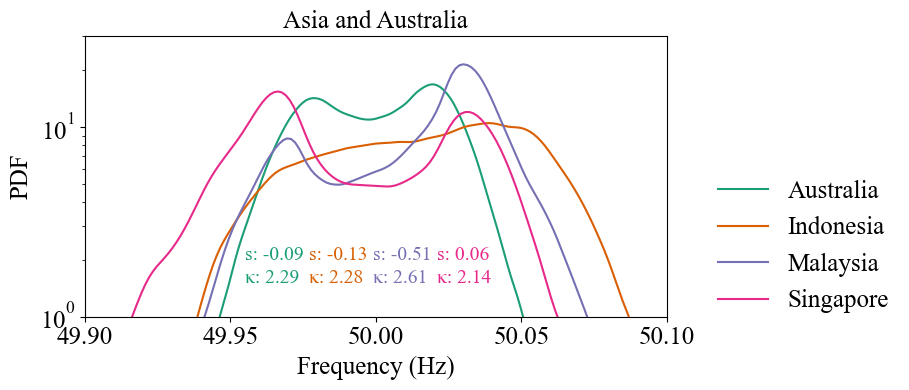

In [41]:
fig, ax = plt.subplots(figsize=(10, 4))

for i, df in enumerate(filter_data):
    data = df['f50']
    # Use Seaborn's kdeplot for plotting Kernel Density Estimation
    sns.kdeplot(data, color=colors[i], ax=ax, label=region_dict[i])
    
# Compute skewness and kurtosis for each dataset's 'f50'
# Appending results to respective lists
skewness = []
kurtosis = []

for df in filter_data:
    skewness.append(df['f50'].skew())           
    kurtosis.append(df['f50'].kurtosis() + 3)   

ax.set_title('Asia and Australia', fontsize=18)
ax.set_xlabel('Frequency (Hz)', fontsize=18)
ax.set_ylabel('PDF', fontsize=18)
ax.set_yscale('log') 
ax.set_xlim([49.9, 50.1])
ax.set_ylim([1, 30])
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)

# Convert skewness and kurtosis lists to numpy arrays for vectorized operations
s = np.array(skewness)
k = np.array(kurtosis)

# Annotate the plot with skewness and kurtosis values, adjusting position for clarity
for i, (skew_val, kurt_val) in enumerate(zip(s, k)):
    ax.text(49.955+i*0.022, 2, f's: {skew_val.item():.2f}', color=colors[i], fontsize=14)
    ax.text(49.955+i*0.022, 1.5, f'\u03ba: {kurt_val.item():.2f}', color=colors[i], fontsize=14)


plt.legend(fontsize=18, bbox_to_anchor=(1.42, 0.25), loc='center right', frameon=False)
plt.tight_layout()
#plt.show()

plt.savefig('C:/4. Paper plots/SRfig2a.pdf')

#### Dip statistics

In [42]:
asia_dip=[]
for i, df in enumerate (filter_data):
    # Perform Dip Test on the 'f50' column after ensuring it's of float type
    dip,pval = diptest.diptest(df['f50'].astype(float))
    region=region_dict[i]
    asia_dip.append((dip))
%store asia_dip

Stored 'asia_dip' (list)


In [43]:
asia_dip

[0.009028756738444709,
 0.0005894460904090176,
 0.011937147005515888,
 0.03782879811190732]

In [38]:
%store asia_dip_hourly_mean

Stored 'asia_dip_hourly_mean' (list)


In [50]:
asia_dip_hourly_mean = []

for i, df in enumerate(filter_data):
    # Make a copy of the DataFrame to ensure we're not modifying a slice
    df_copy = df.copy()
    df_copy['Time'] = pd.to_datetime(df_copy['Time'])
    
    # Now work with df_copy for further operations
    hourly_groups = df_copy.groupby(df_copy['Time'].dt.floor('H'))
    
    hourly_dips = []
    for _, group in hourly_groups:
        dip, pval = diptest.diptest(group['f50'].values)
        hourly_dips.append(dip)
    
    mean_dip = np.mean(hourly_dips)
    asia_dip_hourly_mean.append(mean_dip)

In [51]:
asia_dip_hourly_mean

[0.011968872371648698,
 0.010505001348787051,
 0.02055509099977056,
 0.024992666575417797]

In [6]:
asia_dip_hourly_std = []

for i, df in enumerate(filter_data):
    # Make a copy of the DataFrame to ensure we're not modifying a slice
    df_copy = df.copy()
    df_copy['Time'] = pd.to_datetime(df_copy['Time'])
    
    # Now work with df_copy for further operations
    hourly_groups = df_copy.groupby(df_copy['Time'].dt.floor('H'))
    
    hourly_dips = []
    for _, group in hourly_groups:
        # Assuming diptest function exists and works correctly
        dip, pval = diptest.diptest(group['f50'].values)
        hourly_dips.append(dip)
    
    std_dip = np.std(hourly_dips)
    asia_dip_hourly_std.append(std_dip)

# Now asia_dip_hourly_std contains the standard deviation for each region
print(asia_dip_hourly_std)

[0.009892113004409904, 0.005771937726252922, 0.021812738093062983, 0.022126009039604544]


In [7]:
%store asia_dip_hourly_std

Stored 'asia_dip_hourly_std' (list)


#### Increment frequency

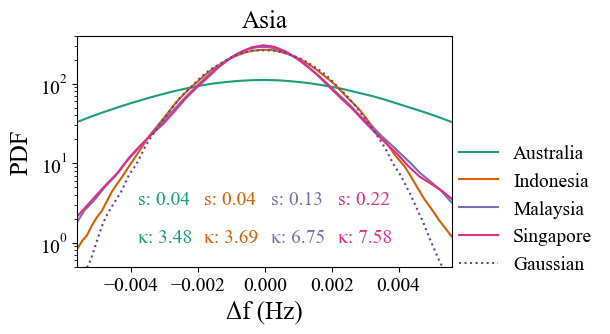

In [12]:
tau=1

fig, ax = plt.subplots(figsize=(6,3))

# Calculate increment frequency and drop NA values
increment_dfs = []
for i, df in enumerate(filter_data):
    df_copy = df.copy()
    df_copy['increment_freq'] = df_copy.iloc[:,1].diff(periods=tau)
    increment_data = df_copy.dropna()
    increment_dfs.append(increment_data)

# Compute skewness and kurtosis for increment frequency
# Appending results to respective lists
skewness = []
kurtosis = []

for df in increment_dfs:
    skewness.append(df['increment_freq'].skew())
    kurtosis.append(df['increment_freq'].kurtosis()+3)

# Plot the filtered data inside the loop
for i, df in enumerate(increment_dfs):
    sns.kdeplot(df['increment_freq'], color=colors[i], ax=ax, label=region_dict[i])
    
# Plot normal distribution curve
sns.kdeplot(random.normal(loc=0, scale=0.0015,size=250000), color= '#6a3d9a', ax=ax, label='Gaussian',linestyle=":")

ax.set_title('Asia',fontsize=18)
ax.set_xlabel('\u0394f (Hz)',fontsize=18)
ax.set_ylabel('PDF',fontsize=18)
ax.set_yscale('log') 

ax.set_xlim([-0.0056,0.0056])
ax.set_ylim([0.5,400])

ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)

# Add skewness and kurtosis annotations
s = skewness  
k = kurtosis 

for i, (skew_val, kurt_val) in enumerate(zip(s, k)):
    ax.text(-0.0038+i*0.002, 3, f's: {skew_val.item():.2f}', color=colors[i], fontsize=14)
    ax.text(-0.0038+i*0.002, 1, f'\u03ba: {kurt_val.item():.2f}', color=colors[i], fontsize=14)

#plt.legend(fontsize=11, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend(fontsize=14,bbox_to_anchor = (1.42, 0.25), loc='center right',frameon=False)

# Adjust subplot spacing
plt.subplots_adjust(right=0.75)


plt.rcParams.update({'font.family': 'Times New Roman'})
#plt.savefig('C:/4. Paper plots/fig 4a.pdf')
plt.show()


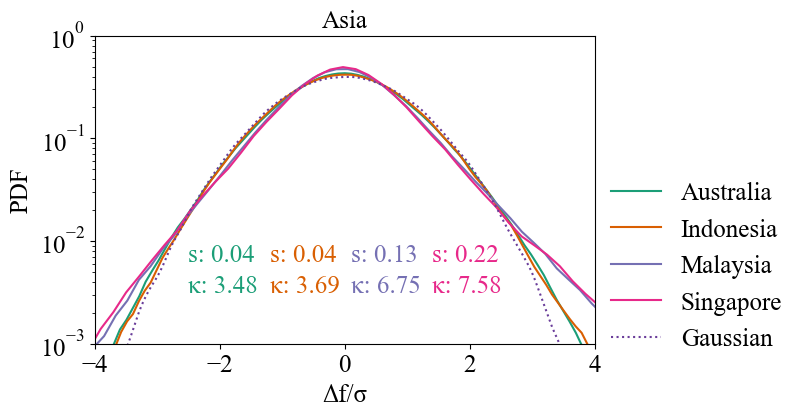

In [24]:
tau = 1

fig, ax = plt.subplots(figsize=(8, 4))

# Calculate increment frequency and drop NA values
increment_dfs = []

for i, df in enumerate(filter_data):
    df_copy = df.copy()
    df_copy['increment_freq'] = df_copy.iloc[:, 1].diff(periods=tau)
    increment_data = df_copy.dropna().copy()  # Create a copy to avoid SettingWithCopyWarning
    
    # Normalize the increment frequency column to have mean 0 and standard deviation 1
    mean = increment_data['increment_freq'].mean()
    std = increment_data['increment_freq'].std()
    increment_data['normalized_increment_freq'] = (increment_data['increment_freq'] - mean) / std
    
    increment_dfs.append(increment_data)

skewness = []
kurtosis = []

for df in increment_dfs:
    skewness.append(df['normalized_increment_freq'].skew())
    kurtosis.append(df['normalized_increment_freq'].kurtosis() + 3)

# Plot the filtered data inside the loop
for i, df in enumerate(increment_dfs):
    sns.kdeplot(df['normalized_increment_freq'], color=colors[i], ax=ax, label=region_dict[i])

# Plot normal distribution curve
sns.kdeplot(random.normal(loc=0, scale=1, size=250000), color='#6a3d9a', ax=ax, label='Gaussian', linestyle=":")

ax.set_title('Asia', fontsize=18)
ax.set_xlabel('Δf/σ', fontsize=18)
ax.set_ylabel('PDF', fontsize=18)
ax.set_yscale('log')

ax.set_xlim([-4,4])
ax.set_ylim([1e-3, 1])

ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)

# Add skewness and kurtosis annotations
s = skewness  
k = kurtosis 

for i, (skew_val, kurt_val) in enumerate(zip(s, k)):
    ax.text(-2.5+i*1.3, 10**-2.2, f's: {skew_val.item():.2f}', color=colors[i], fontsize=18)
    ax.text(-2.5+i*1.3, 10**-2.5, f'\u03ba: {kurt_val.item():.2f}', color=colors[i], fontsize=18)

plt.legend(fontsize=18, bbox_to_anchor=(1.42, 0.25), loc='center right', frameon=False)

# Adjust subplot spacing
plt.subplots_adjust(right=0.75)

plt.rcParams.update({'font.family': 'Times New Roman'})
plt.savefig('C:/4. Paper plots/SRfig4a.pdf')
#plt.show()


#### Autocorrelation plot

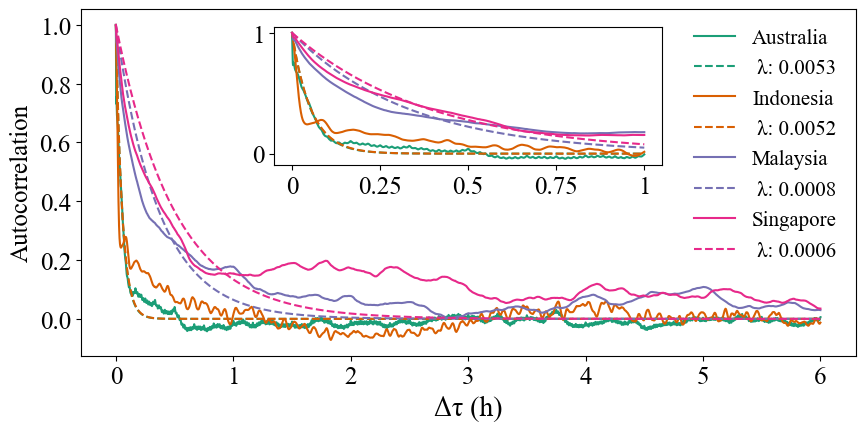

Stored 'asia_lambda' (list)


In [13]:
# Define the exponential decay function
def exp_decay(t, lamb):
    return np.exp(-lamb * t)

asia_lambda = []
asia_lambda_inset = []

fig, ax = plt.subplots(figsize=(10, 4.5))

# Create an inset inside the main ax
axins = ax.inset_axes([0.25, 0.55, 0.50, 0.40]) # [x, y, width, height] of the inset

# Assuming filter_data is a list of dataframes where each dataframe contains data for a region
for i, df in enumerate(filter_data):
    data = df.iloc[:, 1]
    acf_vals = acf(data, nlags=3600*6)
    acf_vals_inset = acf(data, nlags=3600) # This is for the inset
    
    t_values = np.arange(len(acf_vals))
    t_values_inset = np.arange(len(acf_vals_inset))
    
    # Use curve_fit to fit the acf values to the exp_decay function
    popt, _ = curve_fit(exp_decay, t_values, acf_vals, p0=(0.001))
    popt_inset, _ = curve_fit(exp_decay, t_values_inset, acf_vals_inset, p0=(0.001))
    
    lambdas = popt[0]
    asia_lambda.append(lambdas)
    lambda_inset = popt_inset[0] # For the inset
    asia_lambda_inset.append(lambda_inset)
    
    ax.plot(acf_vals, color=colors[i], label=f"{region_dict[i]}")
    ax.plot(exp_decay(t_values, *popt), linestyle='--', 
            color=colors[i], label=f" λ: {lambdas:.4f}")
    
    # Plot on the inset
    axins.plot(acf_vals_inset, color=colors[i])
    axins.plot(exp_decay(t_values_inset, *popt_inset), linestyle='--', 
               color=colors[i], label=f" λ: {lambda_inset:.4f}")

# Set properties of the main plot
ax.set_xlabel('Δτ (h)', fontsize=20)
ax.set_ylabel('Autocorrelation', fontsize=18)
ticks = np.arange(0, 3600*7, 3600)
tick_labels = [f'{i//3600}' for i in ticks]
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels, fontsize=18)
ax.tick_params(axis='y', labelsize=18)  
ax.legend(fontsize=15, loc='upper right', frameon=False)

# Set properties of the inset
#axins.set_title('First 3600 lags')
axins.set_xticks(np.arange(0, 3601, 900)) # Every 15 minutes which is 0.25 hours
axins.set_xticklabels(['0', '0.25', '0.5', '0.75', '1'], fontsize=18)
axins.tick_params(axis='y', labelsize=18)
#axins.legend(fontsize=18, loc='upper right', frameon=False)

plt.savefig('C:/4. Paper plots/SRfig6a.pdf')
plt.show()
%store asia_lambda

#### Linear test

In [27]:
def linear_test (data):
    # Compute Fourier transform 
    fft_0 = np.fft.fft(data)
    
    # Randomize phases of Fourier coefficients
    rand_phases = np.random.uniform(0, 2*np.pi, size=len(fft_0))
    surrogate = np.abs(fft_0) * np.exp(1j * rand_phases)
    
    # Compute inverse Fourier transform to obtain surrogate data
    surrogate = np.real(np.fft.ifft(surrogate))
    
    # Remove NaN values from the data, get the length of the data
    data = data[~np.isnan(data)]
    L = len(data)
    
    # Define the time lags (tau)
    tau = np.arange(1, 82801,540 )
    #tau = np.arange(0, L//2, 3600)
    
    # Initialize arrays to store results
    res_2 = np.zeros(len(tau))
    surr_2 = np.zeros(len(tau))
    
    # Calculate moments for different time lags
    for i in range(len(tau)):
        x_t = data[0 :L-tau[i]]
        x_tau = data[tau[i]:L]
        y_t = surrogate[0:(L-tau[i])]
        y_tau = surrogate[(tau[i]):L]

        res_2[i] = np.mean((x_t-x_tau)**3)/np.mean((x_t-x_tau)**2)
        surr_2[i] = np.mean((y_t-y_tau)**3)/np.mean((y_t-y_tau)**2)
            
    # Calculate the RMSE between the original and surrogate data
    mse_lt2 = mean_squared_error(np.nan_to_num(res_2), np.nan_to_num(surr_2))
    rmse_lt2 = np.sqrt(mse_lt2)
    
    # Return the calculated RMSE
    return rmse_lt2

In [28]:
# Calculate RMSE in linear test for each dataset in dataframes
asia_lt = []
for i, df in enumerate(filter_data):
    data = df.f50.dropna().values
    
    # Calculate RMSE using linear_test function
    rmse_lt2 = linear_test(data)
    
    # Append a tuple containing region name and RMSE to asia_lt list
    asia_lt.append((filter_dict[i], rmse_lt2))
%store asia_lt

Stored 'asia_lt' (list)


In [29]:
asia_lt

[('Australia', 0.0006329233988106432),
 ('Indonesia', 0.0056555903524204065),
 ('Malaysia', 0.0028242310207977745),
 ('Singapore', 0.011492962178922683)]

#### Chapman-Kolmogorov test

In [17]:
def chapman_Kolmogorov_test (data, tau1, tau2, tau3, bins):
    # Extracting data slices for different time lags
    data1 = data[tau1:-tau1] # x3
    data2 = data[tau2:-tau2] # x2
    data3 = data[tau3:-tau3] # x1
    
    # Find bin borders
    dx1 = np.ptp(data3/(bins-1))  # the difference between max and min of data
    dx2 = np.ptp(data2)/(bins-1)
    dx3 = np.ptp(data1)/(bins-1)
    x1 = np.arange(min(data3), np.max(data3)+dx1, dx1)
    x2 = np.arange(min(data2), np.max(data2)+dx2, dx2)
    x3 = np.arange(min(data1), np.max(data1)+dx3, dx3)
    dA = dx1 * dx2
    dV = dx1 * dx2 * dx3
    
    # Finding 2D conditional PDF P(Xt|X(t-1)) or P(x1|x2)
    X = np.column_stack((data3[:len(data3)], data2[:len(data3)]))
    count, edges = np.histogramdd(X, bins=[x1, x2])
    p_12_ref = count/(len(X)*dA)  # Joint PDF of x1, x2
    
    # Calculate 1D PDF p_2
    p_2 = np.zeros(bins-1) # 1d PDF P(x2)
    
    for j in range(bins-1):
        p_2[j] = np.sum(p_12_ref[j,:]) * dx1
        
        # Initialize p_1_2
        p_1_2 = np.zeros((bins-1, bins-1))
        
    # Calculate conditional PDF p_1_2
    for j in range(bins-1):
        if p_2[j] > 0:
            p_1_2[:,j] = p_12_ref[:,j] / p_2[j]

            
    # Set values less than 1e-3 to zero
    p_1_2[p_1_2 < 1e-3] = 0
    
    #Finding 3D conditional PDF P(X_t|X_(t-1),X_(t-2)) or P(x1|x2,x3)
    Y = np.zeros((len(data3), 3))
    Y[:, 0] = data3[:len(data3)]
    Y[:, 1] = data2[:len(data3)]
    Y[:, 2] = data1[:len(data3)]


    edges = (x1, x2, x3)
    count, edges = np.histogramdd(Y, bins=edges)
    mid = [0.5 * (edges[i][1:] + edges[i][:-1]) for i in range(3)]
    loc = np.array(np.unravel_index(np.arange(bins ** 3), (bins, bins, bins)), order='F').T

    # calculate the joint PDF of x2 and x3
    p_123_ref = count / (len(Y) * dV) # % Conditional PDF P(x1|x2,x3)
    p_23 = np.zeros((bins-1, bins-1))
    for i in range(bins-1):
        for j in range(bins-1):
            p_23[i, j] = np.sum(p_123_ref[i, j, :]) * dx1
            
    # calculate the conditional PDF of x1 given x2 and x3
    p_1_23 = np.zeros((bins-1, bins-1, bins-1))
    for i in range(bins-1):
        for j in range(bins-1):
            if p_23[i, j] > 0:
                p_1_23[:, i, j] = p_123_ref[:, i, j] / p_23[i, j]

    
    return x1, x2, p_1_2,p_1_23
    

In [18]:
# Define tau value sets
tau_sets = [
    [2, 4, 6],
    [5,10, 15],
    [20, 40, 60],
    [30, 60, 90],
    [50, 100, 150],
    [70, 140, 210],
    [90, 180, 270],
    [100, 200, 300],
    [200, 400, 600],
    [300, 600, 900],
    [400, 800, 1200],
    [500, 1000, 1500],
    [600, 1200, 1800],
    [700, 1400, 2100],
    [800, 1600, 2400],
    [900, 1800, 2700],
    [1000, 2000, 3000]
    
]

In [19]:
aus_distances=[]

# Iterate through tau value sets
for tau in tau_sets: 
    # Calculate CK test for dataframe
    x1, x2, p_1_2, p_1_23 = chapman_Kolmogorov_test(filter_data[0].f50.dropna().values, tau[0], tau[1], tau[2], 51)
    
    # Normalize p_1_2 and p_1_23
    p_1_2_normalized = p_1_2 / np.sum(p_1_2)
    p_1_23_normalized = p_1_23 / np.sum(p_1_23)
    
    # Calculate distance 
    distance = -np.log(np.sum(np.sqrt(p_1_2_normalized* p_1_23_normalized[:, :, 25])))
    aus_distances.append(distance)

In [20]:
idn_distances=[]

# Iterate through tau value sets
for tau in tau_sets: 
    # Calculate CK test for dataframe
    x1, x2, p_1_2, p_1_23 = chapman_Kolmogorov_test(filter_data[1].f50.dropna().values, tau[0], tau[1], tau[2], 50)
    
    # Normalize p_1_2 and p_1_23
    p_1_2_normalized = p_1_2 / np.sum(p_1_2)
    p_1_23_normalized = p_1_23 / np.sum(p_1_23)
    
    # Calculate distance 
    distance = -np.log(np.sum(np.sqrt(p_1_2_normalized* p_1_23_normalized[:, :, 25])))
    idn_distances.append(distance)

In [21]:
mys_distances=[]

# Iterate through tau value sets
for tau in tau_sets: 
    # Calculate CK test for dataframe
    x1, x2, p_1_2, p_1_23 = chapman_Kolmogorov_test(filter_data[2].f50.dropna().values, tau[0], tau[1], tau[2], 51)
    
    # Normalize p_1_2 and p_1_23
    p_1_2_normalized = p_1_2 / np.sum(p_1_2)
    p_1_23_normalized = p_1_23 / np.sum(p_1_23)
    
    # Calculate distance 
    distance = -np.log(np.sum(np.sqrt(p_1_2_normalized* p_1_23_normalized[:, :, 25])))
    mys_distances.append(distance)

In [22]:
sgp_distances=[]

# Iterate through tau value sets
for tau in tau_sets: 
    # Calculate CK test for dataframe
    x1, x2, p_1_2, p_1_23 = chapman_Kolmogorov_test(filter_data[3].f50.dropna().values, tau[0], tau[1], tau[2], 51)
    
    # Normalize p_1_2 and p_1_23
    p_1_2_normalized = p_1_2 / np.sum(p_1_2)
    p_1_23_normalized = p_1_23 / np.sum(p_1_23)
    
    # Calculate distance 
    distance = -np.log(np.sum(np.sqrt(p_1_2_normalized* p_1_23_normalized[:, :, 25])))
    sgp_distances.append(distance)

Stored 'asia_dis' (list)


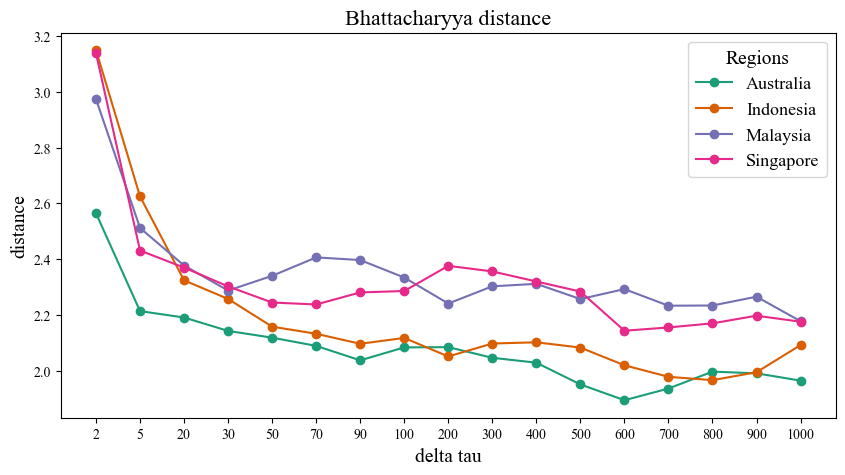

In [23]:
asia_dis=[aus_distances,idn_distances,mys_distances,sgp_distances]
%store asia_dis

fig, ax = plt.subplots(figsize=(10,5))

for i, df in enumerate(asia_dis):
    ax.plot(range(len(tau_sets)),df, 'o-',color=colors[i], label=region_dict[i])
    ax.set_title('Bhattacharyya distance',fontsize=16)
    ax.set_xlabel('delta tau',fontsize=14)
    ax.set_ylabel('distance',fontsize=14)

plt.xticks(range(len(tau_sets)),[2,5,20,30,50,70,90,100,200,300,400,500,600,700,800,900,1000]) 
#ax.set_xticklabels([0,2,5,20,30,50,70,90,100], fontsize=12)
plt.legend(title = "Regions", title_fontsize=14, fontsize=13, loc='upper right')

plt.show()

#### DFA

Slope for Australia: [1.67754133]


C:\Users\wp7528\AppData\Roaming\Python\Python311\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\wp7528\AppData\Roaming\Python\Python311\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Slope for Indonesia: [1.69428657]
Slope for Malaysia: [1.80453649]
Slope for Singapore: [1.79263806]


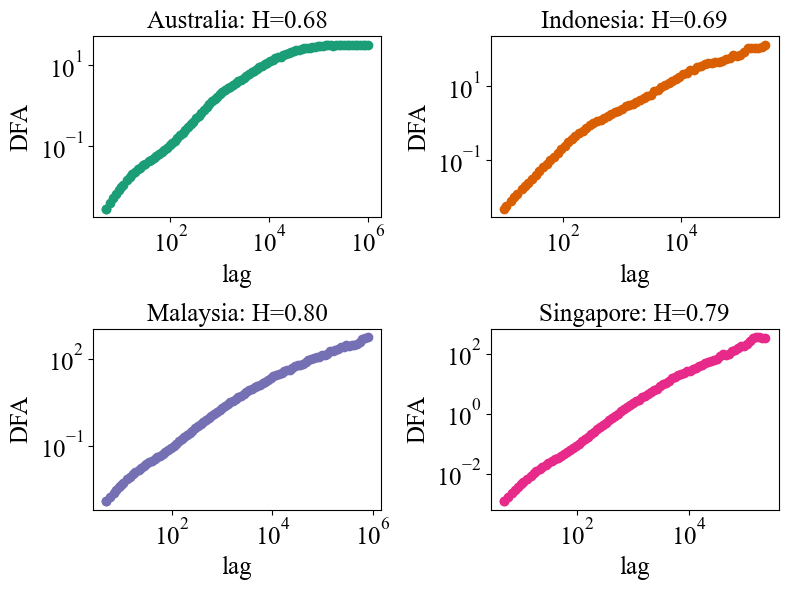

In [14]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

# Define parameters for MFDFA analysis
q = 2
order = 1

for i, df in enumerate(filter_data):
    # Determine the appropriate lag array
    if i == 1:
        lag = np.logspace(1, 7, 100).astype(int)
    else:
        lag = np.logspace(0.7, 6, 100).astype(int)
        
    # Perform MFDFA analysis
    lag, dfa = MFDFA(df['f50'].dropna().values, lag=lag, q=q, order=order)
    ax = axs[i // 2, i % 2]  # Determine the subplot position
    
    # Plot the MFDFA results
    ax.loglog(lag, dfa, 'o', label='fOU: MFDFA q=2', color=colors[i])
    
    # Perform linear fit to calculate Hurst exponent
    polyfit = np.polyfit(np.log(lag[:10]), np.log(dfa[:10]), 1)
    Hurst = polyfit[0] - 1
    
    # Set subplot title and labels
    ax.set_title(f"{region_dict[i]}: H={float(Hurst):.2f}", fontsize=18)
    ax.set_xlabel('lag', fontsize=18)
    ax.set_ylabel('DFA', fontsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.tick_params(axis='x', labelsize=18)

    print(f"Slope for {region_dict[i]}: {polyfit[0]}")

plt.rcParams.update({'font.family': 'Times New Roman'})
plt.tight_layout() 
#plt.show()

plt.savefig('C:/4. Paper plots/SRfig7a.pdf')

Slope for Australia: [1.67754133]


C:\Users\wp7528\AppData\Roaming\Python\Python311\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\wp7528\AppData\Roaming\Python\Python311\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Slope for Indonesia: [1.69428657]
Slope for Malaysia: [1.80453649]
Slope for Singapore: [1.79263806]


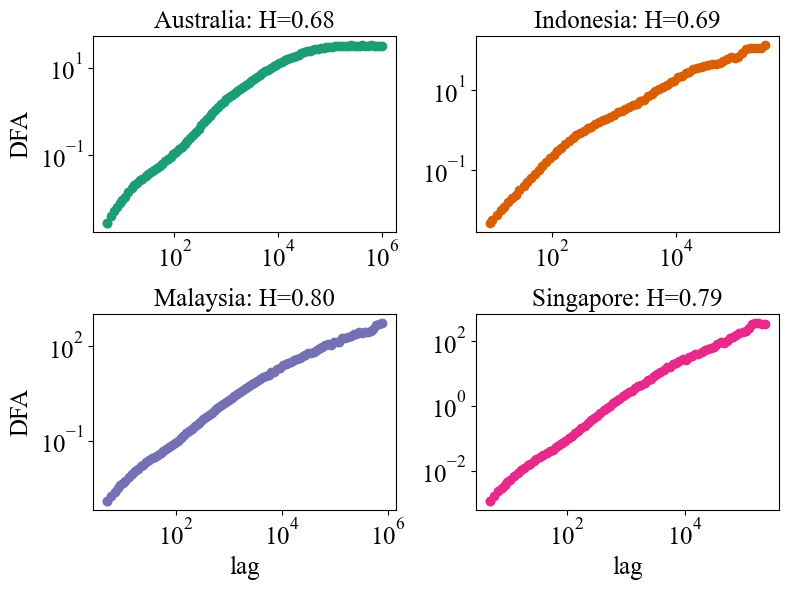

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

# Define parameters for MFDFA analysis
q = 2
order = 1

for i, df in enumerate(filter_data):
    # Determine the appropriate lag array
    if i == 1:
        lag = np.logspace(1, 7, 100).astype(int)
    else:
        lag = np.logspace(0.7, 6, 100).astype(int)
        
    # Perform MFDFA analysis
    lag, dfa = MFDFA(df['f50'].dropna().values, lag=lag, q=q, order=order)
    ax = axs[i // 2, i % 2]  # Determine the subplot position
    
    # Plot the MFDFA results
    ax.loglog(lag, dfa, 'o', label='fOU: MFDFA q=2', color=colors[i])
    
    # Perform linear fit to calculate Hurst exponent
    polyfit = np.polyfit(np.log(lag[:10]), np.log(dfa[:10]), 1)
    Hurst = polyfit[0] - 1
    
    # Set subplot title and labels
    ax.set_title(f"{region_dict[i]}: H={float(Hurst):.2f}", fontsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.tick_params(axis='x', labelsize=18)
    
    if i // 2 == 1:
        ax.set_xlabel('lag', fontsize=18)
    if i % 2 == 0:
        ax.set_ylabel('DFA', fontsize=18)

    print(f"Slope for {region_dict[i]}: {polyfit[0]}")

plt.rcParams.update({'font.family': 'Times New Roman'})
plt.tight_layout()
#plt.show()
plt.savefig('C:/4. Paper plots/SRfig7a.pdf')